# Twitter Tweets Sentiment

Twitter Tweets Sentiment Analysis for Natural Language Processing

Twitter is an online Social Media Platform where people share their their though as tweets. It is observed that some people misuse it to tweet hateful content. Twitter is trying to tackle this problem and we shall help it by creating a strong NLP based-classifier model to distinguish the negative tweets & block such tweets.

In this notebook I have made use of the tensorflow tokenization to convert the data into arrays(after preprocessing it). After tokenizing all the words, I padded them to their respecrive sentences and finally trained the model using LSTM, Dropout, Embedding, Dense, GlobalMaxPool1D. 

At the end, I have attached a model to predict the future tweets as well.

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Importing the data and Preprocessing it 

In [25]:
tweets = pd.read_csv('Tweets.csv')

In [26]:
tweets.head() #Let us check the data set head to see the format of the data

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [27]:
tweets.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [28]:
tweets.info() # This tells us basic info about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [29]:
tweets.isnull().values.any() #Checking Null values 

True

In [30]:
tweets = tweets.dropna() #Droping Null values

In [31]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [32]:
tweets.duplicated().sum() #Checking if there is any duplicate data present

0

In [33]:
tweets['selected_text'].values

array(['I`d have responded, if I were going', 'Sooo SAD', 'bullying me',
       ..., 'Yay good for both of you.', 'But it was worth it  ****.',
       'All this flirting going on - The ATG smiles. Yay.  ((hugs)'],
      dtype=object)

In [34]:
tweets['label_id'] = tweets['sentiment'].factorize()[0] #Creating a label Id that is taken from Sentiment

In [35]:
tweets.head()

,textID,text,selected_text,sentiment,label_id
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1
2,088c60f138,my boss is bullying me...,bullying me,negative,1
3,9642c003ef,what interview! leave me alone,leave me alone,negative,1
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,1


In [36]:
#Creating a new dataframe that only contains teh sentiment and label_id 
categorical_id = tweets[['sentiment', 'label_id']].drop_duplicates().sort_values('label_id')

In [38]:
categorical_id

,sentiment,label_id
0,neutral,0
1,negative,1
6,positive,2


In [40]:
cat_to_id = dict(categorical_id.values)
cat_to_id

{'neutral': 0, 'negative': 1, 'positive': 2}

In [43]:
# Concerting our categorical_if dataset to a dict to train out model
id_to_cat = dict(categorical_id[['label_id', 'sentiment']].values)
id_to_cat

{0: 'neutral', 1: 'negative', 2: 'positive'}

In [44]:
#checking dataset value
label = tweets['label_id'].values
text = tweets['selected_text'].values

In [47]:
print(label)

[0 1 1 ... 2 2 0]


In [48]:
print(text)

['I`d have responded, if I were going' 'Sooo SAD' 'bullying me' ...
 'Yay good for both of you.' 'But it was worth it  ****.'
 'All this flirting going on - The ATG smiles. Yay.  ((hugs)']


Preprocessing is done and now we have our data organized with labels containing the labels and text containing the 
negative comments.

We will not move on to convering the text into an array so that out model can train on it

# Converting the text into array

But first we will have to split out data into test and train sections, so that we can feed out model new words and see it's performance

In [50]:
from sklearn.model_selection import train_test_split

In [72]:
X = text
y = label
print(X.shape)
print(y.shape)

(27480,)
(27480,)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [75]:
X_train.shape

(21984,)

In [76]:
X_test.shape

(5496,)

Now we will move onto tokenization the data into array and pad them so the arrays are the same length 

In [96]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [83]:
vocab_size = 10000
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [85]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, padding=padding_type,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

In [86]:
training_padded[3]

array([ 437,  212,    3,   43,   62,    3,    8,  319, 1006, 6094, 1111,
        276, 1250,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [87]:
training_padded.shape

(21984, 50)

In [88]:
testing_padded.shape

(5496, 50)

In [100]:
X_train = np.array(training_padded)
y_train = np.array(y_train)
X_test = np.array(testing_padded)
y_test = np.array(y_test)

In [101]:
y_train = to_categorical(y_train, num_classes = 3)

In [102]:
y_test = to_categorical(y_test, num_classes = 3)

In [107]:
print(X_train.shape)
print(y_train.shape)

(21984, 50)
(21984, 3)


# Training the Model

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Embedding, Dense, GlobalMaxPool1D
from tensorflow.keras.optimizers import RMSprop

In [109]:
model = Sequential()

model.add(Embedding(input_dim = vocab_size, output_dim = 128, input_length = max_length))
model.add(LSTM(128, return_sequences = True))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))


opt = RMSprop(learning_rate=0.0012, rho=0.7, momentum=0.5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-03-15 14:50:59.835536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-15 14:50:59.836365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 50, 128)           131584    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                          

In [110]:
from tensorflow.keras.callbacks import EarlyStopping

#declare checkpoint variable and early stopping to get best model
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3)

In [111]:
history = model.fit(X_train, y_train,
                    batch_size = 100, epochs = 15, shuffle = True,
                    validation_data=(X_test, y_test), verbose = 1,
                    callbacks=early_stop)

Epoch 1/15


2023-03-15 14:58:10.634187: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-15 14:58:11.971779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-15 14:58:12.318177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-15 14:58:14.236515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - ETA: 0s - loss: 0.7980 - accuracy: 0.6619

2023-03-15 14:58:26.682814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-15 14:58:26.754033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - 17s 58ms/step - loss: 0.7980 - accuracy: 0.6619 - val_loss: 0.5374 - val_accuracy: 0.7939
Epoch 2/15
220/220 [==============================] - 11s 51ms/step - loss: 0.4394 - accuracy: 0.8402 - val_loss: 0.4455 - val_accuracy: 0.8368
Epoch 3/15
220/220 [==============================] - 11s 50ms/step - loss: 0.3206 - accuracy: 0.8887 - val_loss: 0.4591 - val_accuracy: 0.8332
Epoch 4/15
220/220 [==============================] - 11s 50ms/step - loss: 0.2599 - accuracy: 0.9131 - val_loss: 0.5332 - val_accuracy: 0.8255
Epoch 5/15
220/220 [==============================] - 11s 49ms/step - loss: 0.2182 - accuracy: 0.9294 - val_loss: 0.5431 - val_accuracy: 0.8235


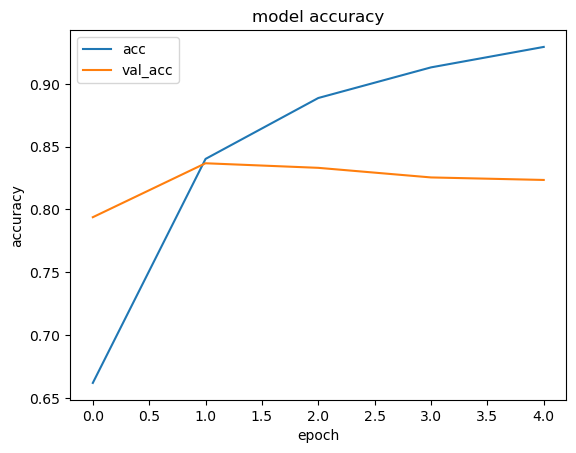

In [112]:
plt.plot (history.history['accuracy'])
plt.plot (history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

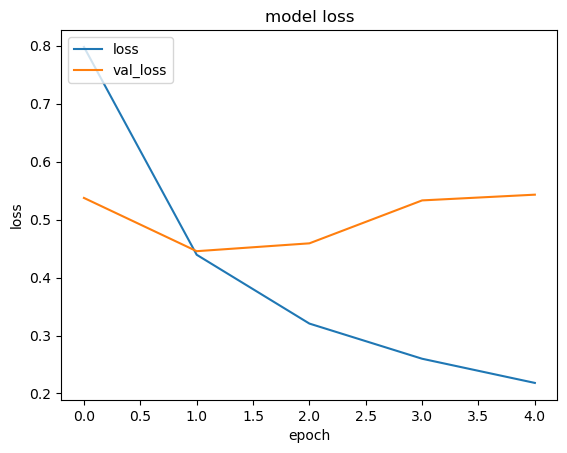

In [113]:
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [114]:
from sklearn.metrics import confusion_matrix, classification_report

In [121]:
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

172/172 [==============================] - 2s 9ms/step
[[1898  185  153]
 [ 279 1243   50]
 [ 191  112 1385]]


In [122]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      2236
           1       0.81      0.79      0.80      1572
           2       0.87      0.82      0.85      1688

    accuracy                           0.82      5496
   macro avg       0.83      0.82      0.82      5496
weighted avg       0.82      0.82      0.82      5496



This model has getten an accuracy of 82.3% on data that it has never seen before!

# To Predict future Tweets

In [150]:
sentence = ["You are amazing!", "Shut up!","I love you!"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))
input_prediction = model.predict(padded)
input_pred_label = np.argmax(input_prediction, axis=1)
print(input_pred_label)
for i in range(len(sentence)):
    if input_pred_label[i] == 2:
        print(f"The Tweet [{sentence[i]}] is Positve")
    elif input_pred_label[i] == 1:
        print(f"The Tweet [{sentence[i]}] is Negative")
    elif input_pred_label[i] == 0:
        print(f"The Tweet [{sentence[i]}] is Neutral")

1/1 [==============================] - 0s 24ms/step
[[2.9449163e-03 4.1681502e-04 9.9663830e-01]
 [2.1261952e-03 9.9396849e-01 3.9053280e-03]
 [3.0227890e-03 6.5522920e-04 9.9632192e-01]]
1/1 [==============================] - 0s 20ms/step
[2 1 2]
The Tweet [You are amazing!] is Positve
The Tweet [Shut up!] is Negative
The Tweet [I love you!] is Positve
